In [413]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import percentileofscore
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor


# EDA

In [417]:
df=pd.read_csv('bicycle.csv')

In [418]:
df.datetime=pd.to_datetime(df.datetime)
df.set_index('datetime',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


index를 datetime으로 바꾼 후, info를 보니 결측치는 없음

## - 종속변수 : count

In [419]:
df['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

나중에 count 수 적음/보통/많음 으로 나누기

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


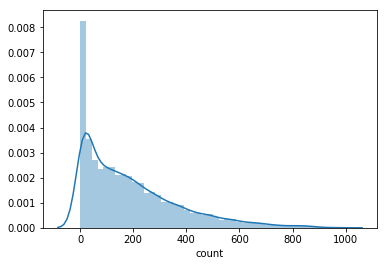

In [124]:
sns.distplot(df['count'])
plt.show()

In [420]:
# casual + registered = count
(df.casual + df.registered != df['count']).sum()

0

casual + registered = count 관계를 가짐    
그럼 casual과 관련된 model , registered와 관련된 model 두개 따로 생각할까 무시할까?

In [422]:
df['casual'].describe()

count    10886.000000
mean        36.021955
std         49.960477
min          0.000000
25%          4.000000
50%         17.000000
75%         49.000000
max        367.000000
Name: casual, dtype: float64

In [423]:
df['registered'].describe()

count    10886.000000
mean       155.552177
std        151.039033
min          0.000000
25%         36.000000
50%        118.000000
75%        222.000000
max        886.000000
Name: registered, dtype: float64

목표가 전체 count수 예측이니 그냥 casual, registered 구분하지 말고 전체 count만 고려하자

## - 독립변수: 12개

In [24]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

### (season)


In [424]:
df.season.value_counts()

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64

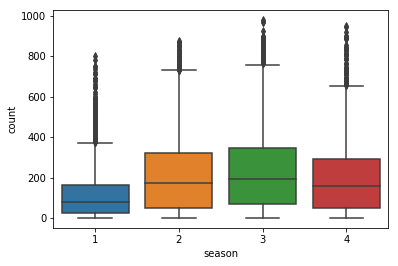

In [425]:
sns.boxplot(x='season',y='count',data=df)
plt.show()

In [426]:
df.groupby('season').mean()['count']

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: count, dtype: float64

계절별로 count수에 어느 정도 차이가 있어보임

### (holiday, workingday)

holiday는 holiday인지 아닌지를 의미.    
workingday는 일 가는 날인지 안가는 날인지를 의미.   
   
따라서 holiday는 workingday에 포함되니, 둘 중 하나만 쓰는게 좋을 것 같다

In [427]:
df.holiday.value_counts()

0    10575
1      311
Name: holiday, dtype: int64

holiday수가 너무 적다.

In [428]:
df.workingday.value_counts()

1    7412
0    3474
Name: workingday, dtype: int64

holiday보단 양호하다.

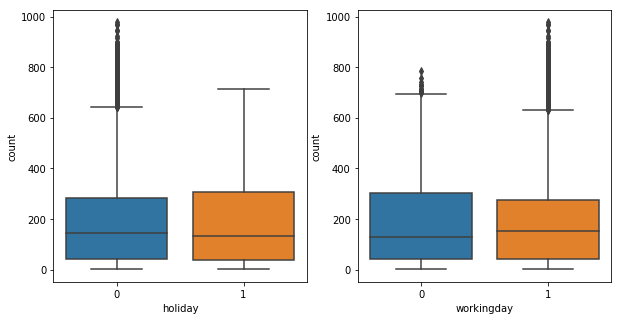

In [429]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
sns.boxplot(x='holiday',y='count',data=df,ax=ax1)

ax2 = fig.add_subplot(1,2,2)
sns.boxplot(x='workingday',y='count',data=df,ax=ax2)

plt.show()

holiday인 날은 굉장히 적고, 게다가 count수에 큰 영향을 주지도 않으니, holiday변수를 빼자.

### (weather)

In [430]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

weather이 4인 경우는 거의 없으니 3이랑 합치기

In [431]:
df.weather = df.weather.replace(4,3)
df.weather.value_counts()

1    7192
2    2834
3     860
Name: weather, dtype: int64

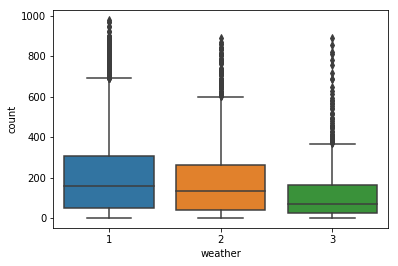

In [432]:
sns.boxplot(x='weather',y='count',data=df)
plt.show()

In [433]:
df.groupby('weather').mean()['count']

weather
1    205.236791
2    178.955540
3    118.898837
Name: count, dtype: float64

weather은 count수에 꽤 영향이 있는듯. 좋을수록 count수 증가

### (temp, atemp)

temp는 온도를 의미.   
atemp는 체감온도를 의미.   
    
둘이 상관관계가 매우 높을 듯 보임. 너무 높으면 둘 중 하나만 쓰기   
경험상 온도보다는 체감온도가 count랑 더 관련있을 것 같음


In [435]:
df.loc[:,['temp','atemp','count']].corr()

,temp,atemp,count
temp,1.000000,0.984948,0.394454
atemp,0.984948,1.000000,0.389784
count,0.394454,0.389784,1.000000


temp와 atemp는 상관관계가 너무 높으니 둘 중 하나만 쓰기.   
temp와 count의 상관관계가 atemp보다 0.04 정도 더 높게 나타남.   
사실상 count와의 상관관계는 둘이 큰 차이는 없고, 경험상 체감온도가 더 영향이 크니 atemp만 쓰자.     

### (humidity)

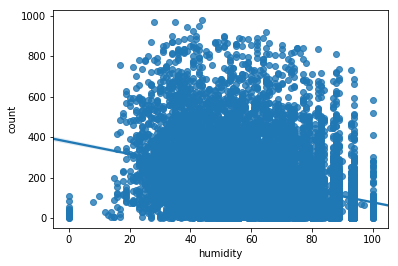

In [436]:
sns.regplot(x=df.humidity, y=df['count'])
plt.show()

In [437]:
df.loc[:,['humidity','count']].corr()

,humidity,count
humidity,1.000000,-0.317371
count,-0.317371,1.000000


count수에 - 방향으로 영향을 조금 끼치는것 같음.    
상식적으로도 습도가 높을 수록 rent하는 사람이 줄어드는게 맞는 것 같음

### (windspeed)

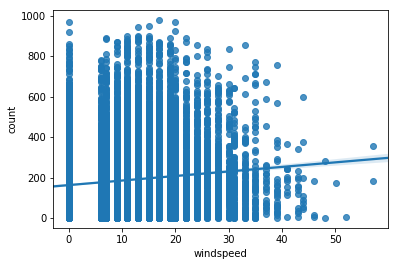

In [438]:
sns.regplot(x='windspeed', y='count', data=df)
plt.show()

In [439]:
df.loc[:,['windspeed','count']].corr()

,windspeed,count
windspeed,1.000000,0.101369
count,0.101369,1.000000


크게는 상관이 없어보인다. 삭제해도 될 것 같은데 일단 냅두기

### (datetime)

count란 게 사람들이 rent를 하는 수이니, 사람들이 활동하는 시간일 수록 count가 높을 것이다.    
그니까 time별로 count수를 보고, time을 잘 활동 안하는 시간/ 조금 활동 하는 시간 / 많이 활동하는 시간 으로 나눠보자.   
    
이때 사람들이 활동하는 시간은 workingday와 관련이 깊을 것 같다.   
workingday ==0 일때랑 ==1일때 시간별로 count수가 어떻게 변하는지를 확인해보기

In [59]:
## 1월 ##

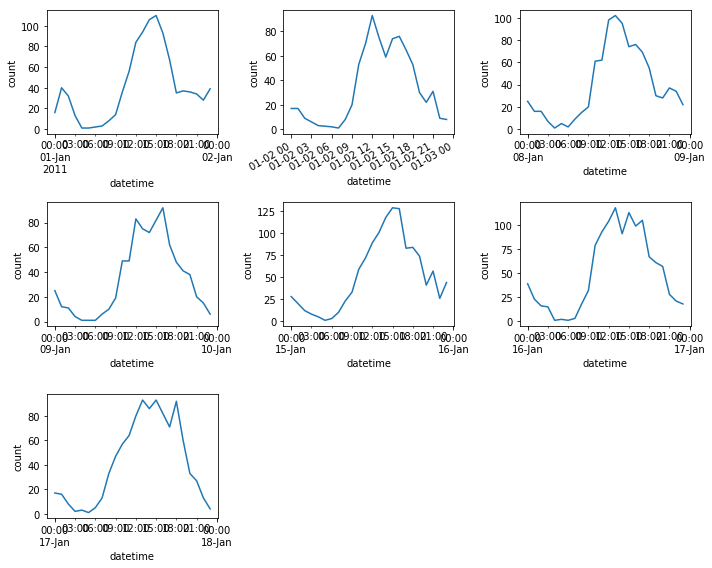

In [440]:
# workingday == 0 / 일하러 안가는 날

fig = plt.figure(figsize=(10,8))

a = df['2011-01-01':'2011-01-19'].resample('D').mean()
for i,d in enumerate(a[a.workingday == 0].index):
    
    ax = fig.add_subplot(3,3,i+1)
    df.loc[str(d).split()[0],'count'].plot(ax=ax)
    plt.ylabel('count')

plt.tight_layout()
plt.show()

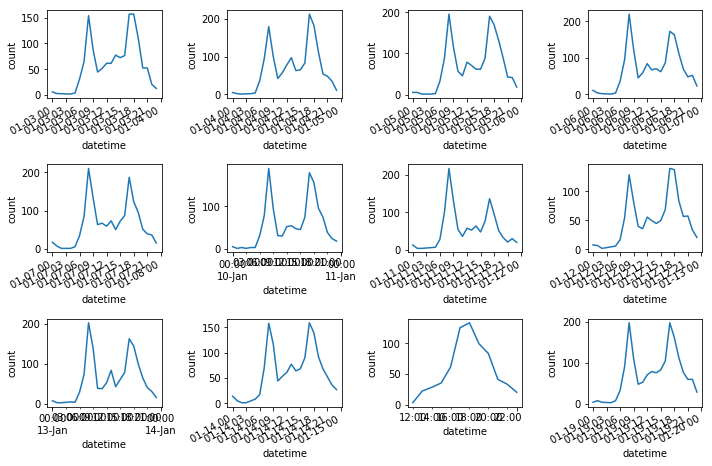

In [441]:
# workingday == 1 / 일하러 가는 날

fig = plt.figure(figsize=(10,8))

a = df['2011-01-01':'2011-01-19'].resample('D').mean()
for i,d in enumerate(a[a.workingday == 1].index):
    
    ax = fig.add_subplot(4,4,i+1)
    df.loc[str(d).split()[0],'count'].plot(ax=ax)  
    plt.ylabel('count')

plt.tight_layout()
plt.show()

In [62]:
## 2월 ##

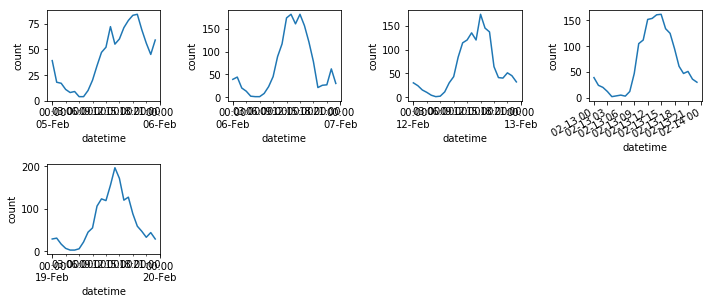

In [442]:
# workingday == 0 / 일하러 안가는 날

fig = plt.figure(figsize=(10,8))

a = df['2011-02-01':'2011-02-19'].resample('D').mean()
for i,d in enumerate(a[a.workingday == 0].index):
    
    ax = fig.add_subplot(4,4,i+1)
    df.loc[str(d).split()[0],'count'].plot(ax=ax)
    plt.ylabel('count')
    
plt.tight_layout()
plt.show()

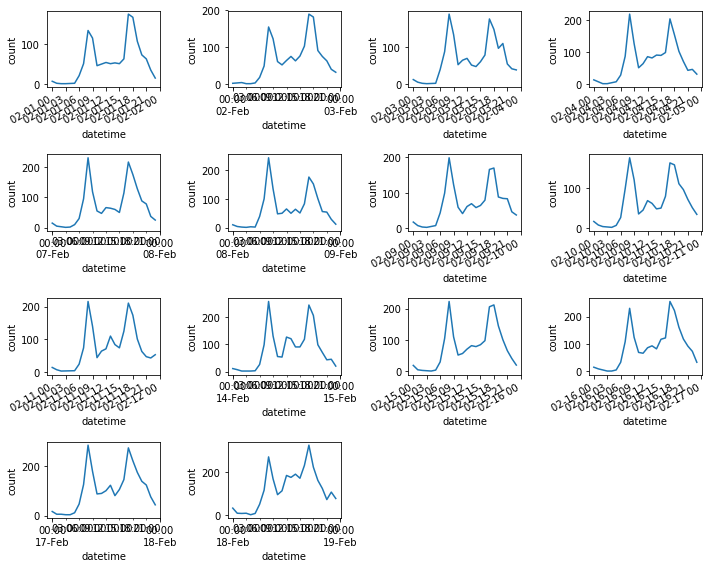

In [443]:
# workingday == 1 / 일하러 가는 날

fig = plt.figure(figsize=(10,8))

a = df['2011-02-01':'2011-02-19'].resample('D').mean()
for i,d in enumerate(a[a.workingday == 1].index):
    
    ax = fig.add_subplot(4,4,i+1)
    df.loc[str(d).split()[0],'count'].plot(ax=ax)
    plt.ylabel('count')
    
plt.tight_layout()
plt.show()


In [65]:
# 3월 #

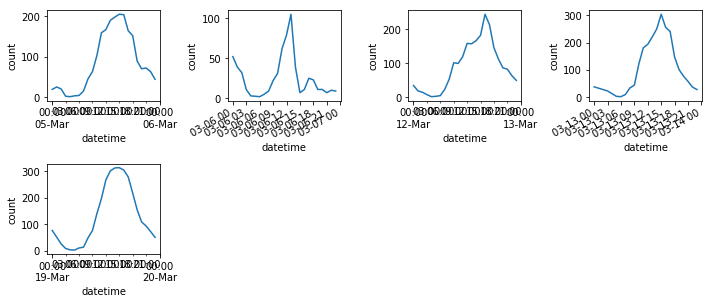

In [444]:
# workingday == 0 / 일하러 안가는 날

fig = plt.figure(figsize=(10,8))

a = df['2011-03-01':'2011-03-19'].resample('D').mean()
for i,d in enumerate(a[a.workingday == 0].index):
    
    ax = fig.add_subplot(4,4,i+1)
    df.loc[str(d).split()[0],'count'].plot(ax=ax)
    plt.ylabel('count')
    
plt.tight_layout()
plt.show()

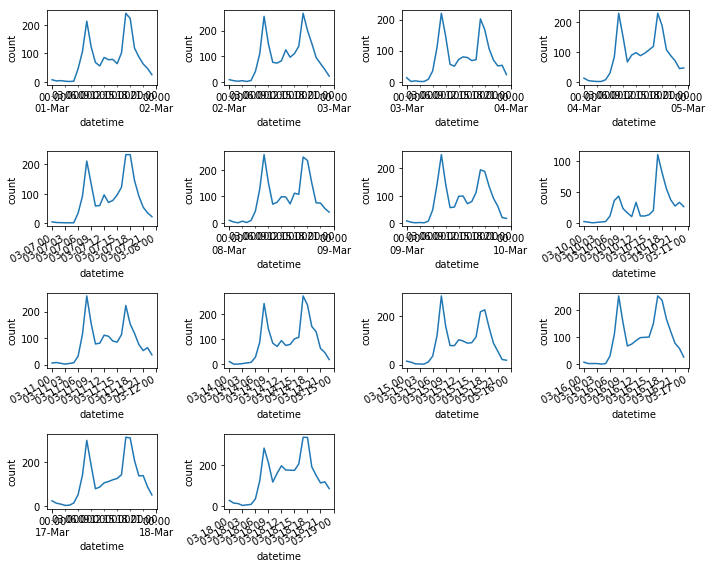

In [445]:
# workingday == 1 / 일하러 가는 날

fig = plt.figure(figsize=(10,8))

a = df['2011-03-01':'2011-03-19'].resample('D').mean()
for i,d in enumerate(a[a.workingday == 1].index):
    
    ax = fig.add_subplot(4,4,i+1)
    df.loc[str(d).split()[0],'count'].plot(ax=ax)
    plt.ylabel('count')
    
plt.tight_layout()
plt.show()


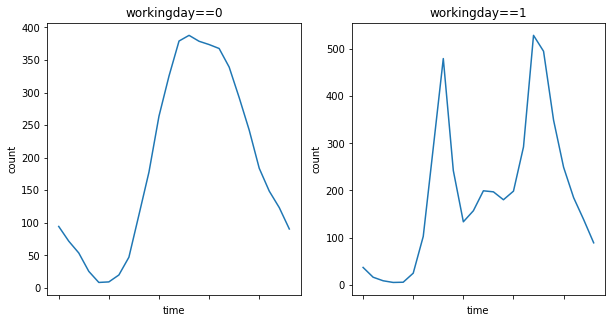

In [446]:
# 마지막으로 전체 count수 평균 data로 비교해보기

time = []

for i in df.index:
    time.append(str(i).split()[1])

df['time']=time

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
df[df.workingday==0].groupby('time').mean()['count'].plot(ax=ax1)
ax1.set_title('workingday==0')
plt.ylabel('count')

ax2 = fig.add_subplot(1,2,2)
df[df.workingday==1].groupby('time').mean()['count'].plot(ax=ax2)
ax2.set_title('workingday==1')
plt.ylabel('count')


plt.show()

# 각 시간대별 전체 count평균 그래프에서도 똑같이 나타남

일하러 가는 날은 출근시간, 퇴근 시간 총 2번 count수가 급격히 증가하는 것 처럼 보이고,    
일하러 안가는 날은 오후에 1변 count가 증가하는 것처럼 보임

사람들이 많이 활동하는 시간에 count수가 올라감.    
따라서 count수를 보면서, count 수를 기준으로 사람들이 주로 활동하는 시간을 3가지 정도로 나눠서 0,1,2 로 점수를 주는 time_premium변수를 만들고 싶음   
   
이때 workingday인지 아닌지에 따라서 사람들이 활동하는 패턴이 다르니, workingday일때 time_premium 시간과 workingday아닐때 time_premium시간이 달라야 된다고 생각.


각 날짜에서 count수의   ~25% /25~75%/75%~ 구간으로 나눈 후, ~25% 구간이 많은 시간대는 0, 25~75% 구간이 많은 시간대는 1, 75%~ 구간이 많은 시간대는 2를 주자.    
     
이때 모든 날마다 일일이 보면서 어느 시간대에 어느 구간이 많은지 확인하는 건 불가능 하니까, season 별로 각 시간대의 count수의 평균을 구해서 사람들이 활동하는 시간을 파악해보자.

In [447]:
# workingday == 0 #

df[(df.season==1) & (df.workingday==0)].groupby('time').mean()['count']

time
00:00:00     49.305556
01:00:00     41.555556
02:00:00     31.764706
03:00:00     16.428571
04:00:00      5.222222
05:00:00      3.757576
06:00:00      6.000000
07:00:00     18.333333
08:00:00     51.194444
09:00:00     80.916667
10:00:00    136.611111
11:00:00    177.166667
12:00:00    220.361111
13:00:00    237.138889
14:00:00    237.027778
15:00:00    242.722222
16:00:00    228.416667
17:00:00    198.138889
18:00:00    159.277778
19:00:00    114.944444
20:00:00     85.750000
21:00:00     71.833333
22:00:00     63.833333
23:00:00     44.666667
Name: count, dtype: float64

In [92]:
df[(df.season==1) & (df.workingday==0)].groupby('time').mean()['count'].describe()
# ~39.107843(25%) : 적게 활동하는 시간
# 39.107843(25%)~182.409722(75%) : 보통으로 활동하는 시간
# 182.409722(75%)~ : 많이 활동하는 시간

count     24.000000
mean     105.098647
std       85.582335
min        3.757576
25%       39.107843
50%       76.375000
75%      182.409722
max      242.722222
Name: count, dtype: float64

In [448]:
# 이런식으로 workingday ==0 일때 4 계절을 모두 확인해보니

# 0, 1                 : count수가 주로 25%~75% 였음. 즉 사람들이 보통으로 활동하는 시간 -> time_premium: 1
# 2 3 4 5 6 7          : count수가 주로 ~25% 였음.    즉 사람들이 잘 활동안하는 시간     -> time_premium: 0
# 8 9 10               : count수가 주로 25%~75% 였음. 즉 사람들이 보통으로 활동하는 시간 -> time_premium: 1
# 11 12 13 14 15 16 17 : count수가 주로 75%~ 였음.    즉 사람들이 많이 활동하는 시간     -> time_premium: 2 
# 18 19 20 21 22 23    : count수가 주로 25%~75% 였음. 즉 사람들이 보통으로 활동하는 시간 -> time_premium: 1

a0 = df[df.workingday==0].time.isin(['02:00:00','03:00:00','04:00:00','05:00:00','06:00:00','07:00:00'])
a1 = df[df.workingday==0].time.isin(['00:00:00','01:00:00','08:00:00','09:00:00','10:00:00','18:00:00','19:00:00','20:00:00','21:00:00','22:00:00','23:00:00'])
a2 = df[df.workingday==0].time.isin(['11:00:00','12:00:00','13:00:00','14:00:00','15:00:00','16:00:00','17:00:00'])

df.loc[df.workingday==0,'a0']=a0.tolist()
df.loc[df.workingday==0,'a1']=a1.tolist()
df.loc[df.workingday==0,'a2']=a2.tolist()

df.loc[df.a0==True,'time_premium']=0
df.loc[df.a1==True,'time_premium']=1
df.loc[df.a2==True,'time_premium']=2

In [449]:
# 이런식으로 workingday ==1 일때 4 계절을 모두 확인해보니

# 0 1 2 3 4 5       : count수가 주로 ~25% 였음.    즉 사람들이 잘 활동안하는 시간     -> time_premium: 0
# 6                 : count수가 주로 25%~75% 였음. 즉 사람들이 보통으로 활동하는 시간 -> time_premium: 1
# 7 8 9             : count수가 주로 75%~ 였음.    즉 사람들이 많이 활동하는 시간     -> time_premium: 2 
# 10 11 12 13 14 15 : count수가 주로 25%~75% 였음. 즉 사람들이 보통으로 활동하는 시간 -> time_premium: 1
# 16 17 18 19       : count수가 주로 75%~ 였음.    즉 사람들이 많이 활동하는 시간     -> time_premium: 2 
# 20 21 22 23       : count수가 주로 25%~75% 였음. 즉 사람들이 보통으로 활동하는 시간 -> time_premium: 1

b0 = df[df.workingday==1].time.isin(['00:00:00','01:00:00','02:00:00','03:00:00','04:00:00','05:00:00'])
b1 = df[df.workingday==1].time.isin(['06:00:00','10:00:00','11:00:00','12:00:00','13:00:00','14:00:00','15:00:00','20:00:00','21:00:00','22:00:00','23:00:00'])
b2 = df[df.workingday==1].time.isin(['07:00:00','08:00:00','09:00:00','16:00:00','17:00:00','18:00:00','19:00:00'])

df.loc[df.workingday==1,'b0']=b0.tolist()
df.loc[df.workingday==1,'b1']=b1.tolist()
df.loc[df.workingday==1,'b2']=b2.tolist()

df.loc[df.b0==True,'time_premium']=0
df.loc[df.b1==True,'time_premium']=1
df.loc[df.b2==True,'time_premium']=2

In [450]:
df.drop(['a0','a1','a2','b0','b1','b2'],inplace=True, axis=1)

In [452]:
df.loc[:,['workingday','time_premium']]

,workingday,time_premium
datetime,,
2011-01-01 00:00:00,0,1.0
2011-01-01 01:00:00,0,1.0
2011-01-01 02:00:00,0,0.0
2011-01-01 03:00:00,0,0.0
2011-01-01 04:00:00,0,0.0
2011-01-01 05:00:00,0,0.0
2011-01-01 06:00:00,0,0.0
2011-01-01 07:00:00,0,0.0
2011-01-01 08:00:00,0,1.0


사람들이 많이 활동하는 시간을 나타내는 time_premium이 상식적인 시간대랑 잘 맞는 것 같음

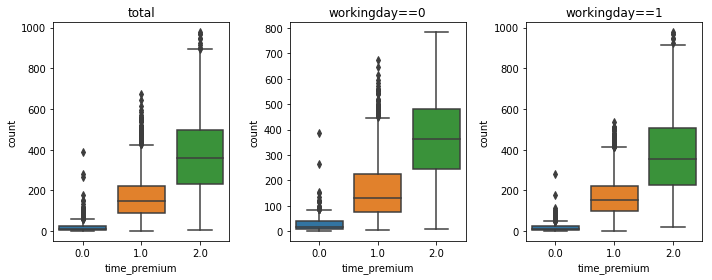

In [453]:
fig = plt.figure(figsize=(10,4))

ax1=fig.add_subplot(1,3,1)
sns.boxplot(x='time_premium',y='count',data=df,ax=ax1)
ax1.set_title('total')

ax2=fig.add_subplot(1,3,2)
sns.boxplot(x='time_premium',y='count',data=df[df.workingday==0],ax=ax2)
ax2.set_title('workingday==0')

ax3=fig.add_subplot(1,3,3)
sns.boxplot(x='time_premium',y='count',data=df[df.workingday==1],ax=ax3)
ax3.set_title('workingday==1')

plt.tight_layout()
plt.show()

### (종속변수:count)

종속변수를 적음/보통/많음 3 class로 나누기

In [454]:
df['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

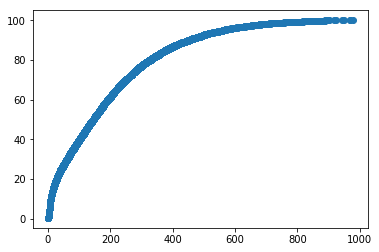

In [456]:
df['percentile']=df['count'].apply(lambda x:percentileofscore(df['count'],x))
plt.plot(df['count'],df['percentile'],'o')
plt.show()

In [457]:
print('30th percentile score:', np.min(df.loc[df['percentile'] > 30, 'count']))
print('Minimum Score needed for 70th percentile:', np.min(df.loc[df['percentile'] > 70, 'count']))

df.drop('percentile',axis=1,inplace=True)
# 주어진 data의 count수에서    ~30%, 즉     ~ 62 count를 적음
#                           30%~70%, 즉 63 ~ 250 count를 보통
#                           70%~   , 즉 251~     count를 많음 으로 나누자

# 그러면 적음/보통/많음 각 class별로 data수가 30%/40%/30% 니까 적당히 나뉘는거 같음

30th percentile score: 62
Minimum Score needed for 70th percentile: 250


In [458]:
df.loc[df['count']<=62,'count_level']='L'
df.loc[ (df['count']>62)&(df['count']<=250),'count_level']='M'
df.loc[ df['count']>250,'count_level']='H'

In [459]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time,time_premium,count_level
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,00:00:00,1.0,L
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,01:00:00,1.0,L
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,02:00:00,0.0,L
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,03:00:00,0.0,L
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,04:00:00,0.0,L


# Model fitting - Classification

## : Logistic, LDA, Naive Bayes,Random Forest,Gradient Boosted Tree

기존 변수들 -> 기존 변수들에서 holiday, temp삭제 -> time_premium 추가   
   
이런 순서로 accuracy를 비교해보면서, holiday와 temp를 삭제할 건지, time_premium을 쓸건지 판단해보자.

In [462]:
def evaluate(X_train,X_test,y_train,y_test):
    # Name of models
    model_name_list=['Logistic','LDA','Naive','RandomForest','GBT']
    
    model1 = LogisticRegression()
    model2 = LinearDiscriminantAnalysis()
    model3 = GaussianNB()
    model4 = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42)
    model5 = GradientBoostingClassifier(n_estimators=100,max_depth=8,random_state=42)
    
    
    # DataFrame for result
    result = pd.DataFrame()
     
    # Train and predict with each model
    accuracy=[]
        
    for i, model in enumerate([model1,model2,model3,model4,model5]):
        accuracy.append(cross_val_score(model,X_train,y_train,cv=5).mean())
     
    result['model'] = ['Logistic','LDA','Naive','RandomForest','GBT']
    result['accuracy'] = accuracy
    
    
    return result

In [463]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'time',
       'time_premium', 'count_level'],
      dtype='object')

### - 독립변수1: 기존 변수들

In [464]:
X = df.loc[:,['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed']]
y = df['count_level']

In [465]:
X.info()
# seasons 변수는 dummy처리 해야할듯?

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 8 columns):
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
dtypes: float64(3), int64(5)
memory usage: 1.1 MB


In [466]:
X['season'] = X['season'].apply(str)
X_dummy = pd.get_dummies(X, drop_first=True)
X_dummy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 10 columns):
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
season_2      10886 non-null uint8
season_3      10886 non-null uint8
season_4      10886 non-null uint8
dtypes: float64(3), int64(4), uint8(3)
memory usage: 1.0 MB


In [467]:
X_dummy.shape, y.shape

((10886, 10), (10886,))

In [468]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy,y,test_size=0.3, random_state=42)

In [469]:
X_train.shape, X_test.shape

((7620, 10), (3266, 10))

In [470]:
result1 = evaluate(X_train,X_test,y_train,y_test)
result1

,model,accuracy
0,Logistic,0.540286
1,LDA,0.539372
2,Naive,0.496325
3,RandomForest,0.561282
4,GBT,0.546978


### -독립변수2: 기존변수들+holiday,temp삭제

In [347]:
### holiday, temp 삭제 ###

X = df.loc[:,['season', 'workingday', 'weather', 'atemp',
       'humidity', 'windspeed']]
y = df['count_level']


In [348]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 6 columns):
season        10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
dtypes: float64(2), int64(4)
memory usage: 595.3 KB


In [349]:
X['season'] = X['season'].apply(str)
X_dummy = pd.get_dummies(X, drop_first=True)
X_dummy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 8 columns):
workingday    10886 non-null int64
weather       10886 non-null int64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
season_2      10886 non-null uint8
season_3      10886 non-null uint8
season_4      10886 non-null uint8
dtypes: float64(2), int64(3), uint8(3)
memory usage: 542.2 KB


In [350]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy,y,test_size=0.3, random_state=42)

In [351]:
result2 = evaluate(X_train,X_test,y_train,y_test)
result2

,model,accuracy
0,Logistic,0.541076
1,LDA,0.540946
2,Naive,0.496324
3,RandomForest,0.559052
4,GBT,0.543304


Logistic, LDA, Naive는 accuracy가 증가했고, RandomForest,GBT는 약간 감소.    
temp와 holiday는 삭제해도 될듯하다.    

### -독립변수3: 기존변수들+holiday,temp삭제+time_premium사용

In [352]:
### holiday, temp 삭제 + time_premium 사용 ###

X = df.loc[:,['season', 'workingday', 'weather', 'atemp',
       'humidity', 'windspeed','time_premium']]
y = df['count_level']

In [353]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 7 columns):
season          10886 non-null int64
workingday      10886 non-null int64
weather         10886 non-null int64
atemp           10886 non-null float64
humidity        10886 non-null int64
windspeed       10886 non-null float64
time_premium    10886 non-null float64
dtypes: float64(3), int64(4)
memory usage: 680.4 KB


In [354]:
X['season'] = X['season'].apply(str)
X_dummy = pd.get_dummies(X, drop_first=True)
X_dummy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 9 columns):
workingday      10886 non-null int64
weather         10886 non-null int64
atemp           10886 non-null float64
humidity        10886 non-null int64
windspeed       10886 non-null float64
time_premium    10886 non-null float64
season_2        10886 non-null uint8
season_3        10886 non-null uint8
season_4        10886 non-null uint8
dtypes: float64(3), int64(3), uint8(3)
memory usage: 627.2 KB


In [355]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy,y,test_size=0.3, random_state=42)

In [356]:
result3 = evaluate(X_train,X_test,y_train,y_test)
result3

,model,accuracy
0,Logistic,0.781495
1,LDA,0.785432
2,Naive,0.765617
3,RandomForest,0.805249
4,GBT,0.783464


time_premium변수 추가로 accuracy가 많이 올라갔다. 근데 이렇게 변수를 만들어도 되는지 잘 모르겠다.

In [ ]:
# test data로 accuracy 측정해보기

model1 = LogisticRegression()
model2 = LinearDiscriminantAnalysis()
model3 = GaussianNB()
model4 = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42)
model5 = GradientBoostingClassifier(n_estimators=100,max_depth=8,random_state=42)

In [266]:
result5 = pd.DataFrame()
accuracy=[]

for i, model in enumerate([model1,model2,model3,model4,model5]):
    model.fit(X_train,y_train)
    prediction=model.predict(X_test)
    accuracy.append(accuracy_score(prediction,y_test))
     
        
result5['model'] = ['Logistic','LDA','Naive','RandomForest','GBT']
result5['accuracy'] = accuracy

result5
    

,model,accuracy
0,Logistic,0.770055
1,LDA,0.773729
2,Naive,0.765462
3,RandomForest,0.782303
4,GBT,0.785671


In [ ]:
# GridsearchCV 로 정확도 올려보기

model4 = RandomForestClassifier(random_state=42)
model5 = GradientBoostingClassifier(random_state=42)

In [267]:
param_grid = { 
    'n_estimators': [200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,7,8],
    'criterion' :['gini', 'entropy']
}

In [269]:
cv_model4 = GridSearchCV(estimator=model4,param_grid=param_grid,cv=5)
cv_model4.fit(X_train,y_train)
prediction = cv_model4.predict(X_test)
accuracy_score(y_test,prediction)

0.8022045315370484

# Model fitting - Regression

### -독립변수1: 기존변수들

In [ ]:
### 기존 변수들 ###

X = df.loc[:,['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed']]
y = df['count']

In [372]:
X['season'] = X['season'].apply(str)
X_dummy = pd.get_dummies(X, drop_first=True)
X_dummy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 10 columns):
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
season_2      10886 non-null uint8
season_3      10886 non-null uint8
season_4      10886 non-null uint8
dtypes: float64(3), int64(4), uint8(3)
memory usage: 712.3 KB


In [373]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy,y,test_size=0.3, random_state=42)

In [379]:
# LinearRegression

lm = LinearRegression()
steps = [('scaler', StandardScaler()),
         ('linear', LinearRegression())]
pipeline = Pipeline(steps)

rmse=[]

result = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='neg_mean_squared_error')

rmse.append(np.mean(np.sqrt(-result)))

In [382]:
# Ridge

steps = [('scaler', StandardScaler()),
         ('ridge', Ridge())]

pipeline = Pipeline(steps)

parameters = {'ridge__alpha':np.logspace(-4, 0, 50)}

cv = GridSearchCV(pipeline, parameters, cv=10)

cv.fit(X_train, y_train)

prediction=cv.predict(X_test)

rmse.append(np.sqrt(mean_squared_error(y_test, prediction)))

In [384]:
# Lasso

steps = [('scaler', StandardScaler()),
         ('ridge', Lasso())]

pipeline = Pipeline(steps)

parameters = {'ridge__alpha':np.logspace(-4, 0, 50)}

cv = GridSearchCV(pipeline, parameters, cv=10)

cv.fit(X_train, y_train)

prediction=cv.predict(X_test)

rmse.append(np.sqrt(mean_squared_error(y_test, prediction)))

In [386]:
# RandomForest

steps = [('scaler', StandardScaler()),
         ('random', RandomForestRegressor(n_estimators=100,max_depth=8,random_state=42))]

pipeline = Pipeline(steps)

result = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='neg_mean_squared_error')

rmse.append(np.mean(np.sqrt(-result)))

In [391]:
np.round(rmse,2)

array([154.55, 154.01, 153.93, 146.29])

### -독립변수2: 기존변수들+holiday,temp삭제

In [396]:
### holiday, temp 삭제 ###

X = df.loc[:,['season', 'workingday', 'weather', 'atemp',
       'humidity', 'windspeed']]
y = df['count_level']


In [397]:
X['season'] = X['season'].apply(str)
X_dummy = pd.get_dummies(X, drop_first=True)
X_dummy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 8 columns):
workingday    10886 non-null int64
weather       10886 non-null int64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
season_2      10886 non-null uint8
season_3      10886 non-null uint8
season_4      10886 non-null uint8
dtypes: float64(2), int64(3), uint8(3)
memory usage: 542.2 KB


In [398]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy,y,test_size=0.3, random_state=42)

In [399]:
# LinearRegression

lm = LinearRegression()
steps = [('scaler', StandardScaler()),
         ('linear', LinearRegression())]
pipeline = Pipeline(steps)

rmse=[]

result = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='neg_mean_squared_error')

rmse.append(np.mean(np.sqrt(-result)))

In [400]:
# Ridge

steps = [('scaler', StandardScaler()),
         ('ridge', Ridge())]

pipeline = Pipeline(steps)

parameters = {'ridge__alpha':np.logspace(-4, 0, 50)}

cv = GridSearchCV(pipeline, parameters, cv=10)

cv.fit(X_train, y_train)

prediction=cv.predict(X_test)

rmse.append(np.sqrt(mean_squared_error(y_test, prediction)))

In [401]:
# Lasso

steps = [('scaler', StandardScaler()),
         ('ridge', Lasso())]

pipeline = Pipeline(steps)

parameters = {'ridge__alpha':np.logspace(-4, 0, 50)}

cv = GridSearchCV(pipeline, parameters, cv=10)

cv.fit(X_train, y_train)

prediction=cv.predict(X_test)

rmse.append(np.sqrt(mean_squared_error(y_test, prediction)))

In [402]:
# RandomForest

steps = [('scaler', StandardScaler()),
         ('random', RandomForestRegressor(n_estimators=100,max_depth=8,random_state=42))]

pipeline = Pipeline(steps)

result = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='neg_mean_squared_error')

rmse.append(np.mean(np.sqrt(-result)))

In [403]:
np.round(rmse,2)

array([154.83, 154.31, 154.29, 146.86])

### -독립변수3: 기존변수들+holiday,temp삭제+time_premium사용

In [404]:
### holiday, temp 삭제 + time_premium 사용 ###

X = df.loc[:,['season', 'workingday', 'weather', 'atemp',
       'humidity', 'windspeed','time_premium']]
y = df['count']

In [405]:
X['season'] = X['season'].apply(str)
X_dummy = pd.get_dummies(X, drop_first=True)
X_dummy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 9 columns):
workingday      10886 non-null int64
weather         10886 non-null int64
atemp           10886 non-null float64
humidity        10886 non-null int64
windspeed       10886 non-null float64
time_premium    10886 non-null float64
season_2        10886 non-null uint8
season_3        10886 non-null uint8
season_4        10886 non-null uint8
dtypes: float64(3), int64(3), uint8(3)
memory usage: 627.2 KB


In [406]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy,y,test_size=0.3, random_state=42)

In [407]:
# LinearRegression

lm = LinearRegression()
steps = [('scaler', StandardScaler()),
         ('linear', LinearRegression())]
pipeline = Pipeline(steps)

rmse=[]

result = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='neg_mean_squared_error')

rmse.append(np.mean(np.sqrt(-result)))

In [408]:
# Ridge

steps = [('scaler', StandardScaler()),
         ('ridge', Ridge())]

pipeline = Pipeline(steps)

parameters = {'ridge__alpha':np.logspace(-4, 0, 50)}

cv = GridSearchCV(pipeline, parameters, cv=10)

cv.fit(X_train, y_train)

prediction=cv.predict(X_test)

rmse.append(np.sqrt(mean_squared_error(y_test, prediction)))

In [409]:
# Lasso

steps = [('scaler', StandardScaler()),
         ('ridge', Lasso())]

pipeline = Pipeline(steps)

parameters = {'ridge__alpha':np.logspace(-4, 0, 50)}

cv = GridSearchCV(pipeline, parameters, cv=10)

cv.fit(X_train, y_train)

prediction=cv.predict(X_test)

rmse.append(np.sqrt(mean_squared_error(y_test, prediction)))

In [410]:
# RandomForest

steps = [('scaler', StandardScaler()),
         ('random', RandomForestRegressor(n_estimators=100,max_depth=8,random_state=42))]

pipeline = Pipeline(steps)

result = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='neg_mean_squared_error')

rmse.append(np.mean(np.sqrt(-result)))

In [412]:
np.round(rmse,2)

array([107.05, 106.29, 106.29,  94.5 ])

전체결과:   
   
-독립변수1: 기존변수들      
-독립변수2: 기존변수들 + holiday,temp삭제    
-독립변수3: 기존변수들 + holiday,temp삭제 + time_premium사용

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-us36{border-color:inherit;vertical-align:top}
.tg .tg-7btt{font-weight:bold;border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-yw4l{vertical-align:top}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-us36"></th>
    <th class="tg-7btt">model</th>
    <th class="tg-7btt">독립변수1</th>
    <th class="tg-7btt">독립변수2</th>
    <th class="tg-7btt">독립변수3</th>
  </tr>
  <tr>
    <td class="tg-7btt" rowspan="5">Classification<br>(accuracy)</td>
    <td class="tg-us36">Logistic</td>
    <td class="tg-c3ow">0.539892</td>
    <td class="tg-c3ow">0.541076</td>
    <td class="tg-c3ow">0.781495</td>
  </tr>
  <tr>
    <td class="tg-us36">LDA</td>
    <td class="tg-c3ow">0.539503</td>
    <td class="tg-c3ow">0.540946</td>
    <td class="tg-c3ow">0.785432</td>
  </tr>
  <tr>
    <td class="tg-us36">Naive</td>
    <td class="tg-c3ow">0.496194</td>
    <td class="tg-c3ow">0.496324</td>
    <td class="tg-c3ow">0.765617</td>
  </tr>
  <tr>
    <td class="tg-yw4l">RandomForest</td>
    <td class="tg-baqh">0.560232</td>
    <td class="tg-baqh">0.559052</td>
    <td class="tg-baqh">0.805249</td>
  </tr>
  <tr>
    <td class="tg-yw4l">GBT</td>
    <td class="tg-baqh">0.545274</td>
    <td class="tg-baqh">0.543304</td>
    <td class="tg-baqh">0.783464</td>
  </tr>
  <tr>
    <td class="tg-amwm" rowspan="4">Regression<br>(rmse)</td>
    <td class="tg-yw4l">Linear</td>
    <td class="tg-baqh">154.55</td>
    <td class="tg-baqh">154.83</td>
    <td class="tg-baqh">107.05</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Ridge</td>
    <td class="tg-baqh">154.01</td>
    <td class="tg-baqh">154.31</td>
    <td class="tg-baqh">106.29</td>
  </tr>
  <tr>
    <td class="tg-yw4l">Lasso</td>
    <td class="tg-baqh">153.93</td>
    <td class="tg-baqh">154.29</td>
    <td class="tg-baqh">106.29</td>
  </tr>
  <tr>
    <td class="tg-yw4l">RaondomForest</td>
    <td class="tg-baqh">146.29</td>
    <td class="tg-baqh">146.86</td>
    <td class="tg-baqh">94.5</td>
  </tr>
</table>